In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import xgboost as xgb
import statsmodels.api as sm
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
from tensorflow.keras.layers import Conv1D,LSTM,Flatten,Dense,Dropout,MaxPooling1D,RepeatVector,TimeDistributed
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

In [2]:
%matplotlib inline

In [3]:
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
df_weather=pd.read_csv("/content/drive/MyDrive/weather_features.csv",parse_dates=["dt_iso"])
df_energy=pd.read_csv("/content/drive/MyDrive/energy_dataset.csv",parse_dates=["time"])


In [7]:
df_energy=df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],axis=1)

In [ ]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [8]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
df_energy = df_energy.set_index('time')


In [ ]:
print("There are {} NaNs or null values in our dataFrame".format(df_energy.isnull().values.sum()))
print("There are {} duplicated records in our dataFrame".format(df_energy.duplicated(keep='first').sum()))

There are 292 NaNs or null values in our dataFrame
There are 0 duplicated records in our dataFrame


In [ ]:
df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [ ]:
def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series
    created by the user. The user can define either the 'df' and the 'column'
    or the 'series' and additionally, can also define the 'label', the
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

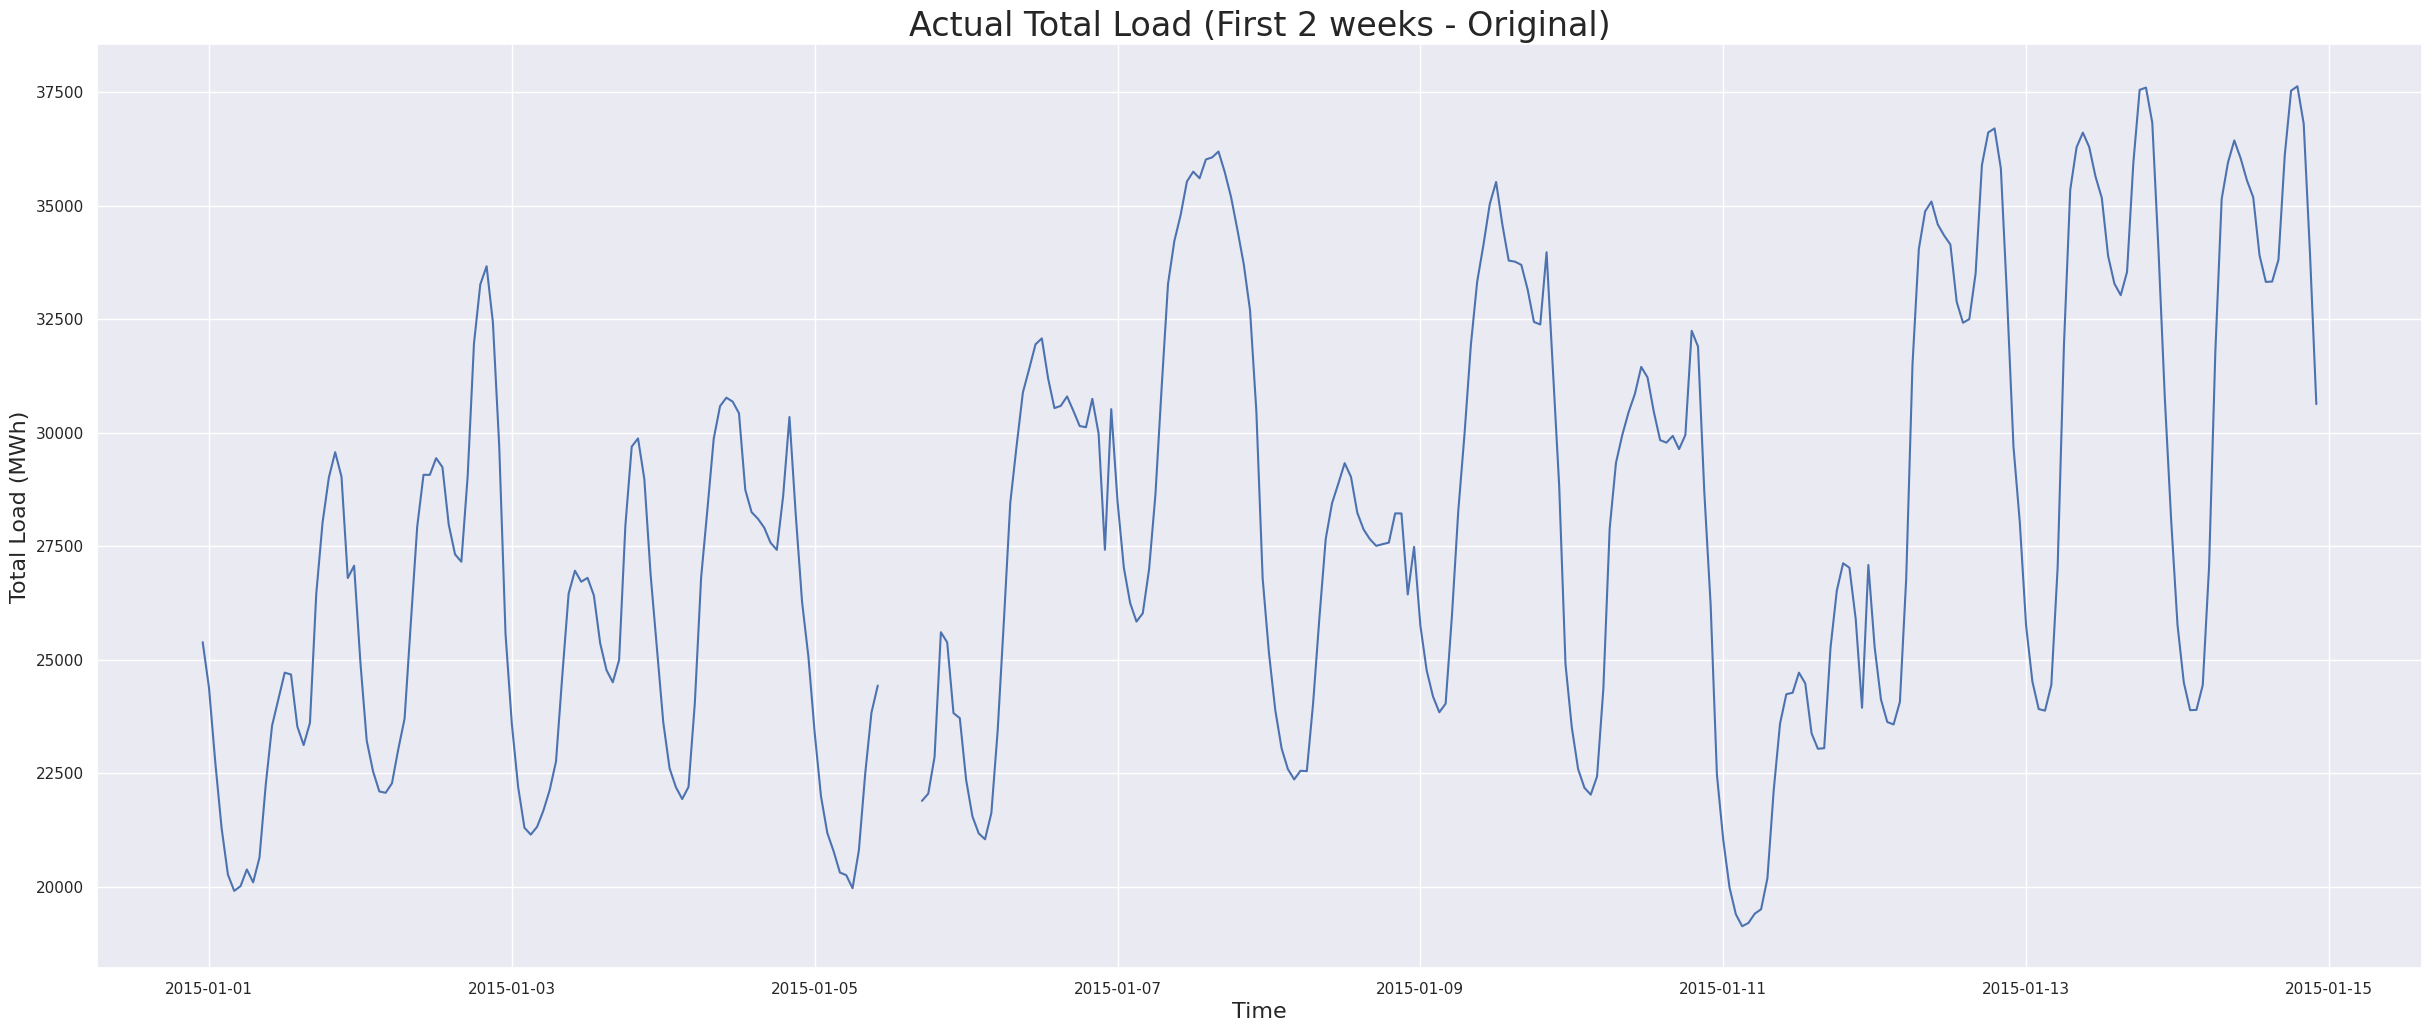

In [ ]:
ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [ ]:
df_energy[df_energy.isnull().any(axis=1)].tail()

generation biomass  \
time                                            
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2016-11-23 03:00:00+00:00                                 900.0   
2017-11-14 11:00:00+00:00                                   0.0   
2017-11-14 18:00:00+00:00                                   0.0   
2018-06-11 16:00:00+00:00                                 506.0   
2018-07-11 07:00:00+00:00                                   NaN   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2016-11-23 03:00:00+00:00                 4838.0                       4547.0   
2017-11-14 11:00:00+00:00                10064.0                          0.0   
2017-11-14 18:00:00+00:00                12336.0                          0.0   
2018-06-11 16:00:00+00:00                 7538.0                       5360.0   
2018-07-11 07:00:00+00:00                    NaN                          NaN   

                           generation fossil oil  \
time                                               
2016-11-23 03:00:00+00:00                  269.0   
2017-11-14 11:00:00+00:00                    0.0   
2017-11-14 18:00:00+00:00                    0.0   
2018-06-11 16:00:00+00:00                  300.0   
2018-07-11 07:00:00+00:00                    NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2016-11-23 03:00:00+00:00                                       1413.0   
2017-11-14 11:00:00+00:00                                          0.0   
2017-11-14 18:00:00+00:00                                          0.0   
2018-06-11 16:00:00+00:00                                          1.0   
2018-07-11 07:00:00+00:00                                          NaN   

                           generation hydro run-of-river and poundage  \
time                                                                    
2016-11-23 03:00:00+00:00                                       795.0   
2017-11-14 11:00:00+00:00                                         0.0   
2017-11-14 18:00:00+00:00                                         0.0   
2018-06-11 16:00:00+00:00                                      1134.0   
2018-07-11 07:00:00+00:00                                         NaN   

                           generation hydro water reservoir  \
time                                                          
2016-11-23 03:00:00+00:00                             435.0   
2017-11-14 11:00:00+00:00                               0.0   
2017-11-14 18:00:00+00:00                               0.0   
2018-06-11 16:00:00+00:00                            4258.0   
2018-07-11 07:00:00+00:00                               NaN   

                           generation nuclear  generation other  \
time                                                              
2016-11-23 03:00:00+00:00              5040.0              60.0   
2017-11-14 11:00:00+00:00                 0.0               0.0   
2017-11-14 18:00:00+00:00                 0.0               0.0   
2018-06-11 16:00:00+00:00              5856.0              52.0   
2018-07-11 07:00:00+00:00                 NaN               NaN   

                           generation other renewable  generation solar  \
time                                                                      
2016-11-23 03:00:00+00:00                        85.0              15.0   
2017-11-14 11:00:00+00:00                         0.0               0.0   
2017-11-14 18:00:00+00:00            

In [9]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [ ]:
print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


In [ ]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [10]:
def convertDataType(df,convertFrom,convertTo):
  cols=df.select_dtypes(include=[convertFrom]).columns
  for col in cols:
    df[col]=df[col].values.astype(convertTo)
  return df

In [11]:
df_weather=convertDataType(df_weather,np.int64,np.float64)

In [12]:
df_weather['time']=pd.to_datetime(df_weather['dt_iso'],utc=True)
df_weather=df_weather.drop(['dt_iso'],axis=1)
df_weather=df_weather.set_index('time')

In [ ]:
mean_featuresValues_for_cities = df_weather.drop(['weather_main', 'weather_description', 'weather_icon'], axis=1).groupby('city_name').mean()
mean_featuresValues_for_cities

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [ ]:
print("Total NaNs in dataFrame are: ",df_weather.isnull().values.sum())
print("Total duplicated records in dataFrame are: ",df_weather.duplicated(keep='first').sum())

Total NaNs in dataFrame are:  0
Total duplicated records in dataFrame are:  8622


In [ ]:
# Display the number of rows in each dataframe
print("Number of rows in df_energy: ", df_energy.shape[0])
cities=df_weather['city_name'].unique()
for city in cities:
  print("Number of rows in df_weather for city {}: {}".format(city,df_weather[df_weather['city_name']==city].shape[0]))

Number of rows in df_energy:  35064
Number of rows in df_weather for city Valencia: 35145
Number of rows in df_weather for city Madrid: 36267
Number of rows in df_weather for city Bilbao: 35951
Number of rows in df_weather for city  Barcelona: 35476
Number of rows in df_weather for city Seville: 35557


In [13]:
df_weather2=df_weather.reset_index().drop_duplicates(subset=['city_name','time'],keep='last').set_index('time')
df_weather=df_weather.reset_index().drop_duplicates(subset=['city_name','time'],keep='first').set_index('time')


In [ ]:
# Display the number of rows in each dataframe
print("Number of rows in df_energy: ", df_energy.shape[0])
cities=df_weather['city_name'].unique()
for city in cities:
  print("Number of rows in df_weather for city {}: {}".format(city,df_weather[df_weather['city_name']==city].shape[0]))

Number of rows in df_energy:  35064
Number of rows in df_weather for city Valencia: 35064
Number of rows in df_weather for city Madrid: 35064
Number of rows in df_weather for city Bilbao: 35064
Number of rows in df_weather for city  Barcelona: 35064
Number of rows in df_weather for city Seville: 35064


In [16]:
def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    if column not in df_1.columns or column not in df_2.columns:
        print(f"Column '{column}' not found in one or both dataframes.")
        return

    if categorical:
        le = LabelEncoder()
        combined = pd.concat([df_1[[column]], df_2[[column]]])
        le.fit(combined[column].astype(str)) # Convert to string before fitting

        df_1[column] = le.transform(df_1[column].astype(str)) # Convert to string before transforming
        df_2[column] = le.transform(df_2[column].astype(str)) # Convert to string before transforming

    # Ensure data is numeric before calculating R2 score
    try:
        df_1_numeric = pd.to_numeric(df_1[column], errors='coerce')
        df_2_numeric = pd.to_numeric(df_2[column], errors='coerce')
    except ValueError:
        print(f"Could not convert column '{column}' to numeric type.")
        return


    r2 = r2_score(df_1_numeric.dropna(), df_2_numeric.dropna()) # Drop NaNs that might have been introduced by coercion
    print("R-Squared score of {} is {}".format(column, round(r2, 3)))

In [ ]:
encode_and_display_r2_score(df_weather, df_weather2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_id')

R-Squared score of weather_description is 0.95
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [14]:
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

In [17]:
df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0


In [ ]:
temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


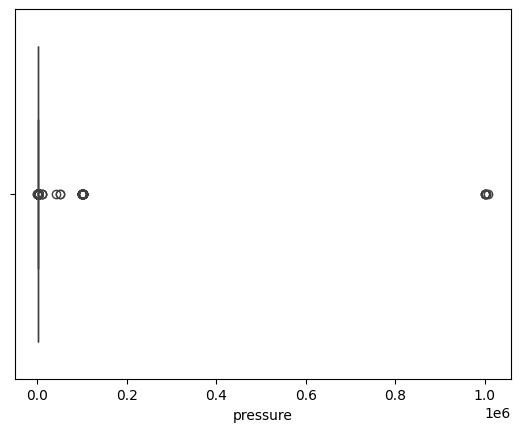

In [ ]:
sns.boxplot(x=df_weather["pressure"])
plt.show()

In [18]:
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

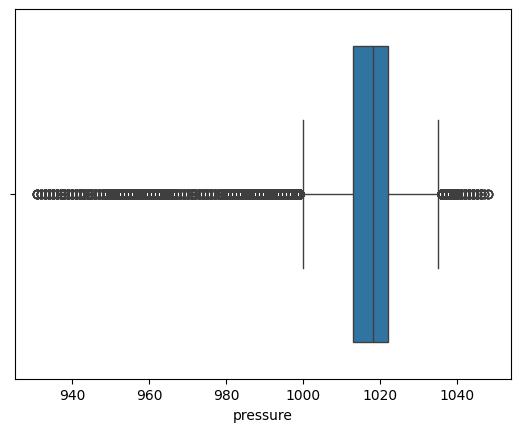

In [19]:
df_weather = df_weather.reset_index()
sns.boxplot(x=df_weather['pressure'])
plt.show()

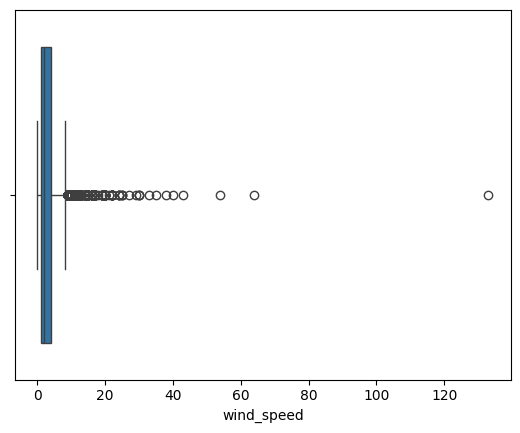

In [ ]:
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [20]:

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

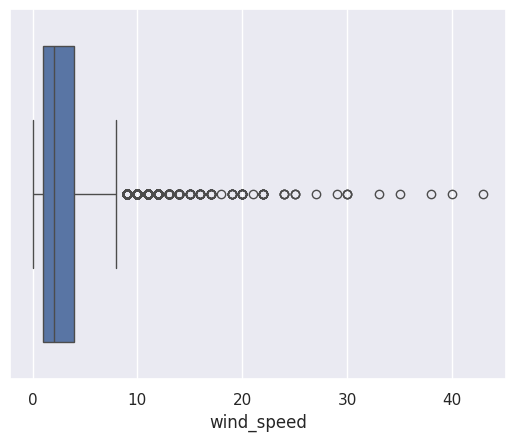

In [ ]:
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [21]:
df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

/tmp/ipython-input-21-4288544281.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


In [22]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [23]:
df_final = df_energy.reset_index()

for df in dfs:
    city = df['city_name'].iloc[0]
    df_final = df_final.merge(df, on=['time'], how='outer')
    city_str = str(city).replace("'", "").replace(' ', '')
    # Rename columns from the merged df to add city suffix, except for 'time'
    cols_to_rename = {col: f"{col}_{city_str}" for col in df.columns if col != 'time'}
    df_final = df_final.rename(columns=cols_to_rename)
    df_final = df_final.drop(f'city_name_{city_str}', axis=1)


df_final = df_final.set_index('time')
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clo

In [ ]:
print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


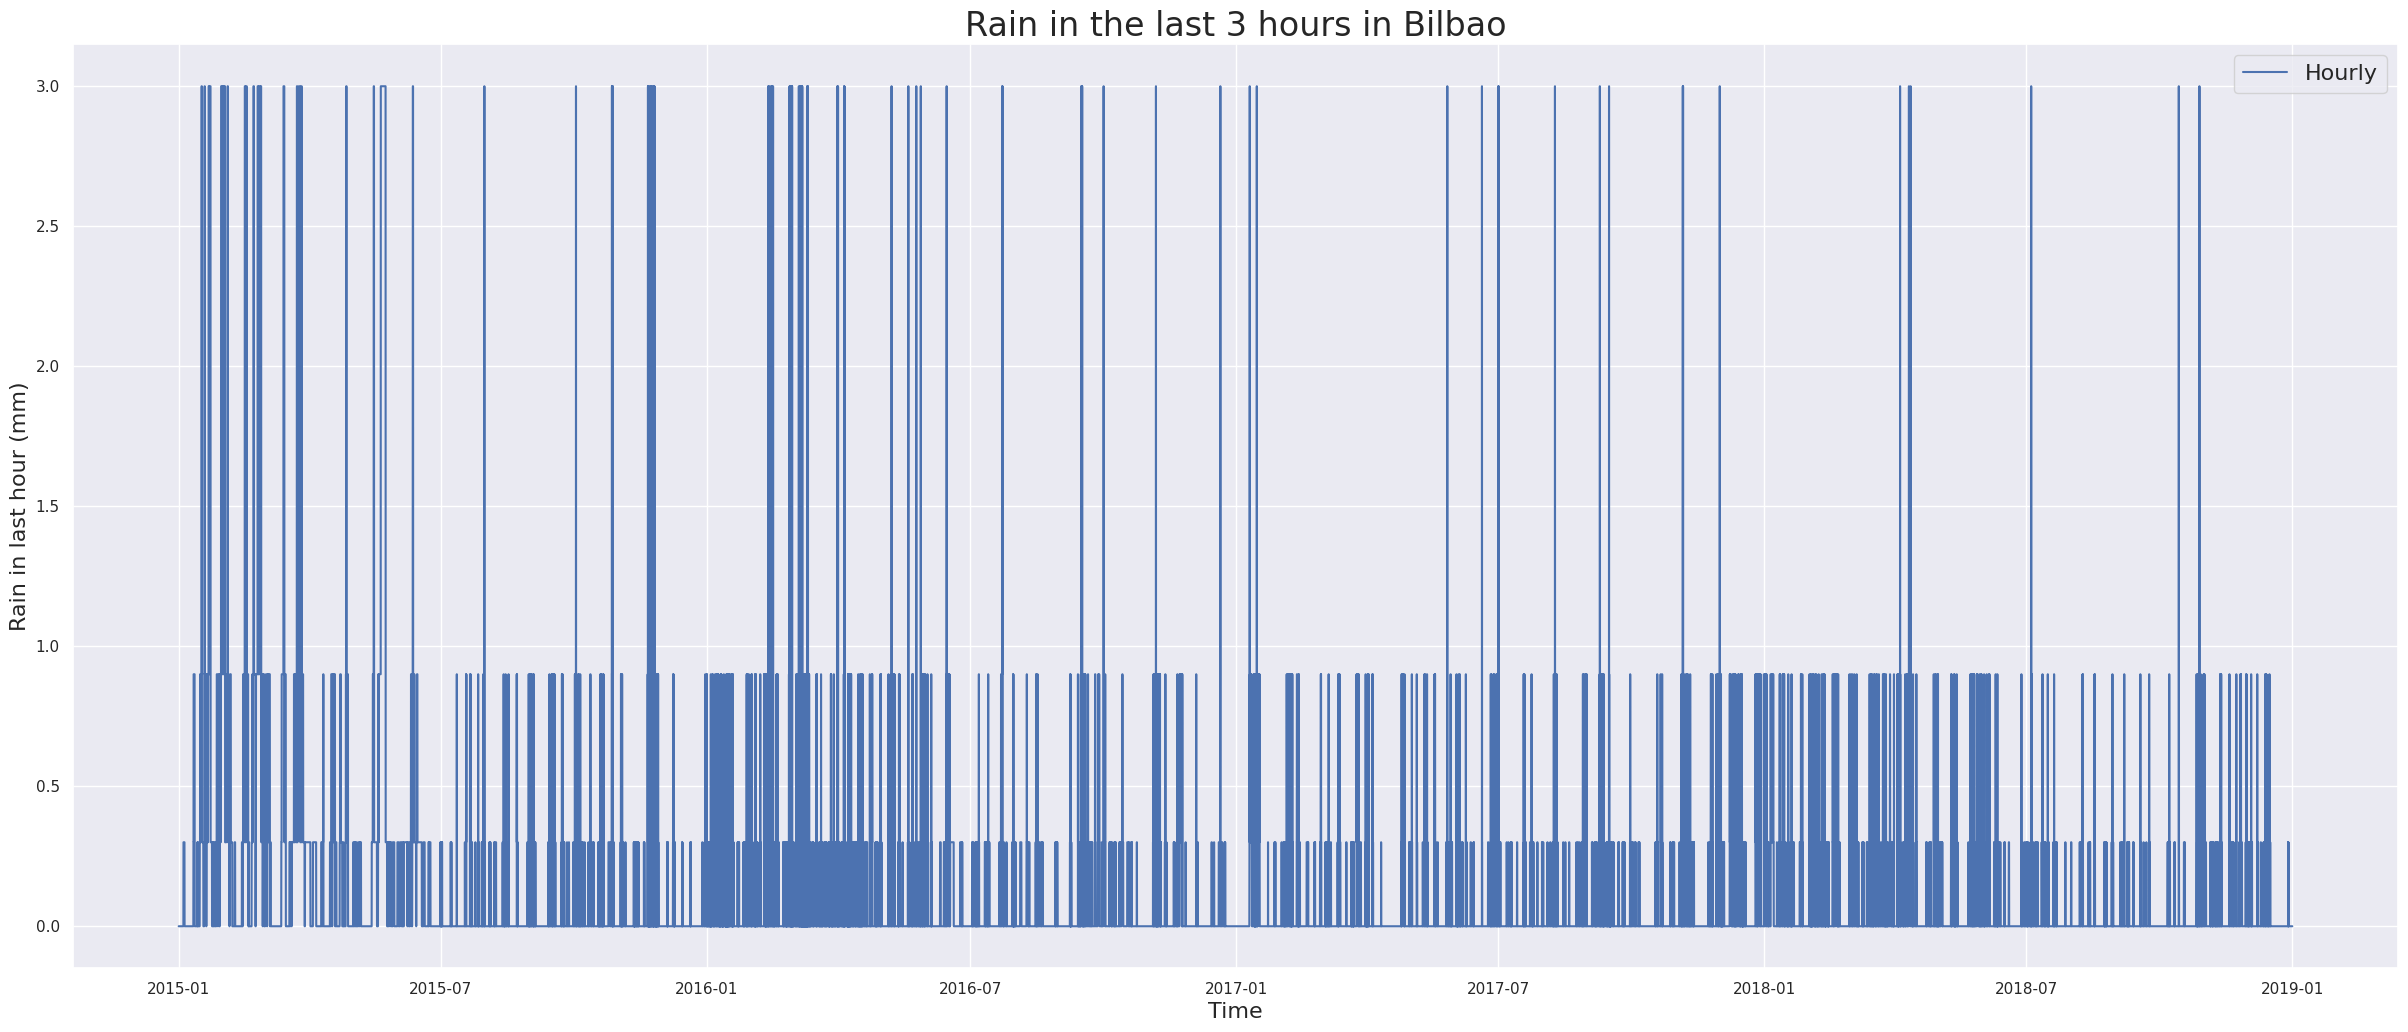

In [ ]:
ax = plot_series(df_final, 'rain_1h_Bilbao',
                 label='Hourly', ylabel='Rain in last hour (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

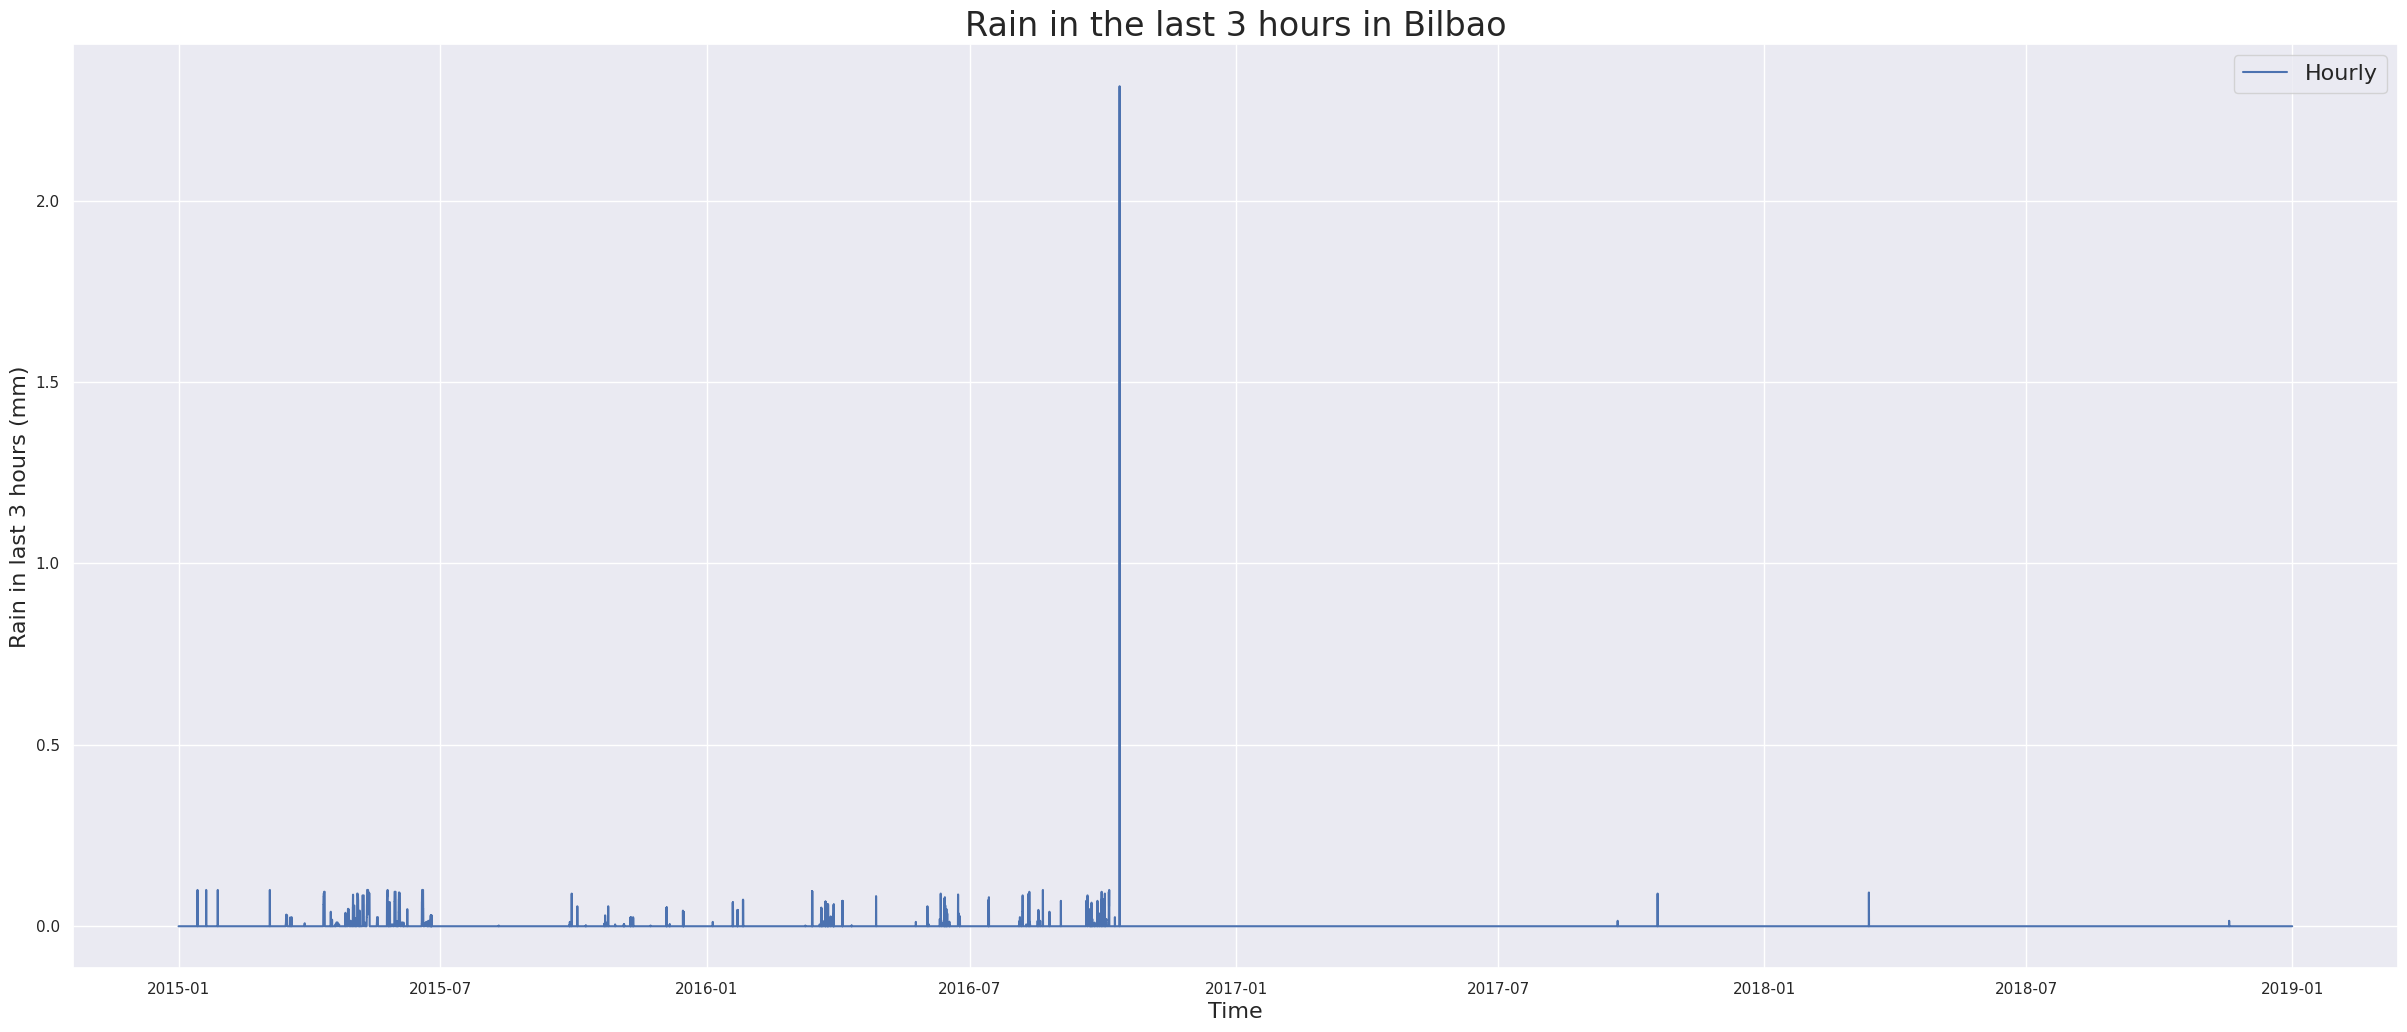

In [ ]:
ax = plot_series(df_final, 'rain_3h_Bilbao',
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

In [ ]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

In [ ]:
rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

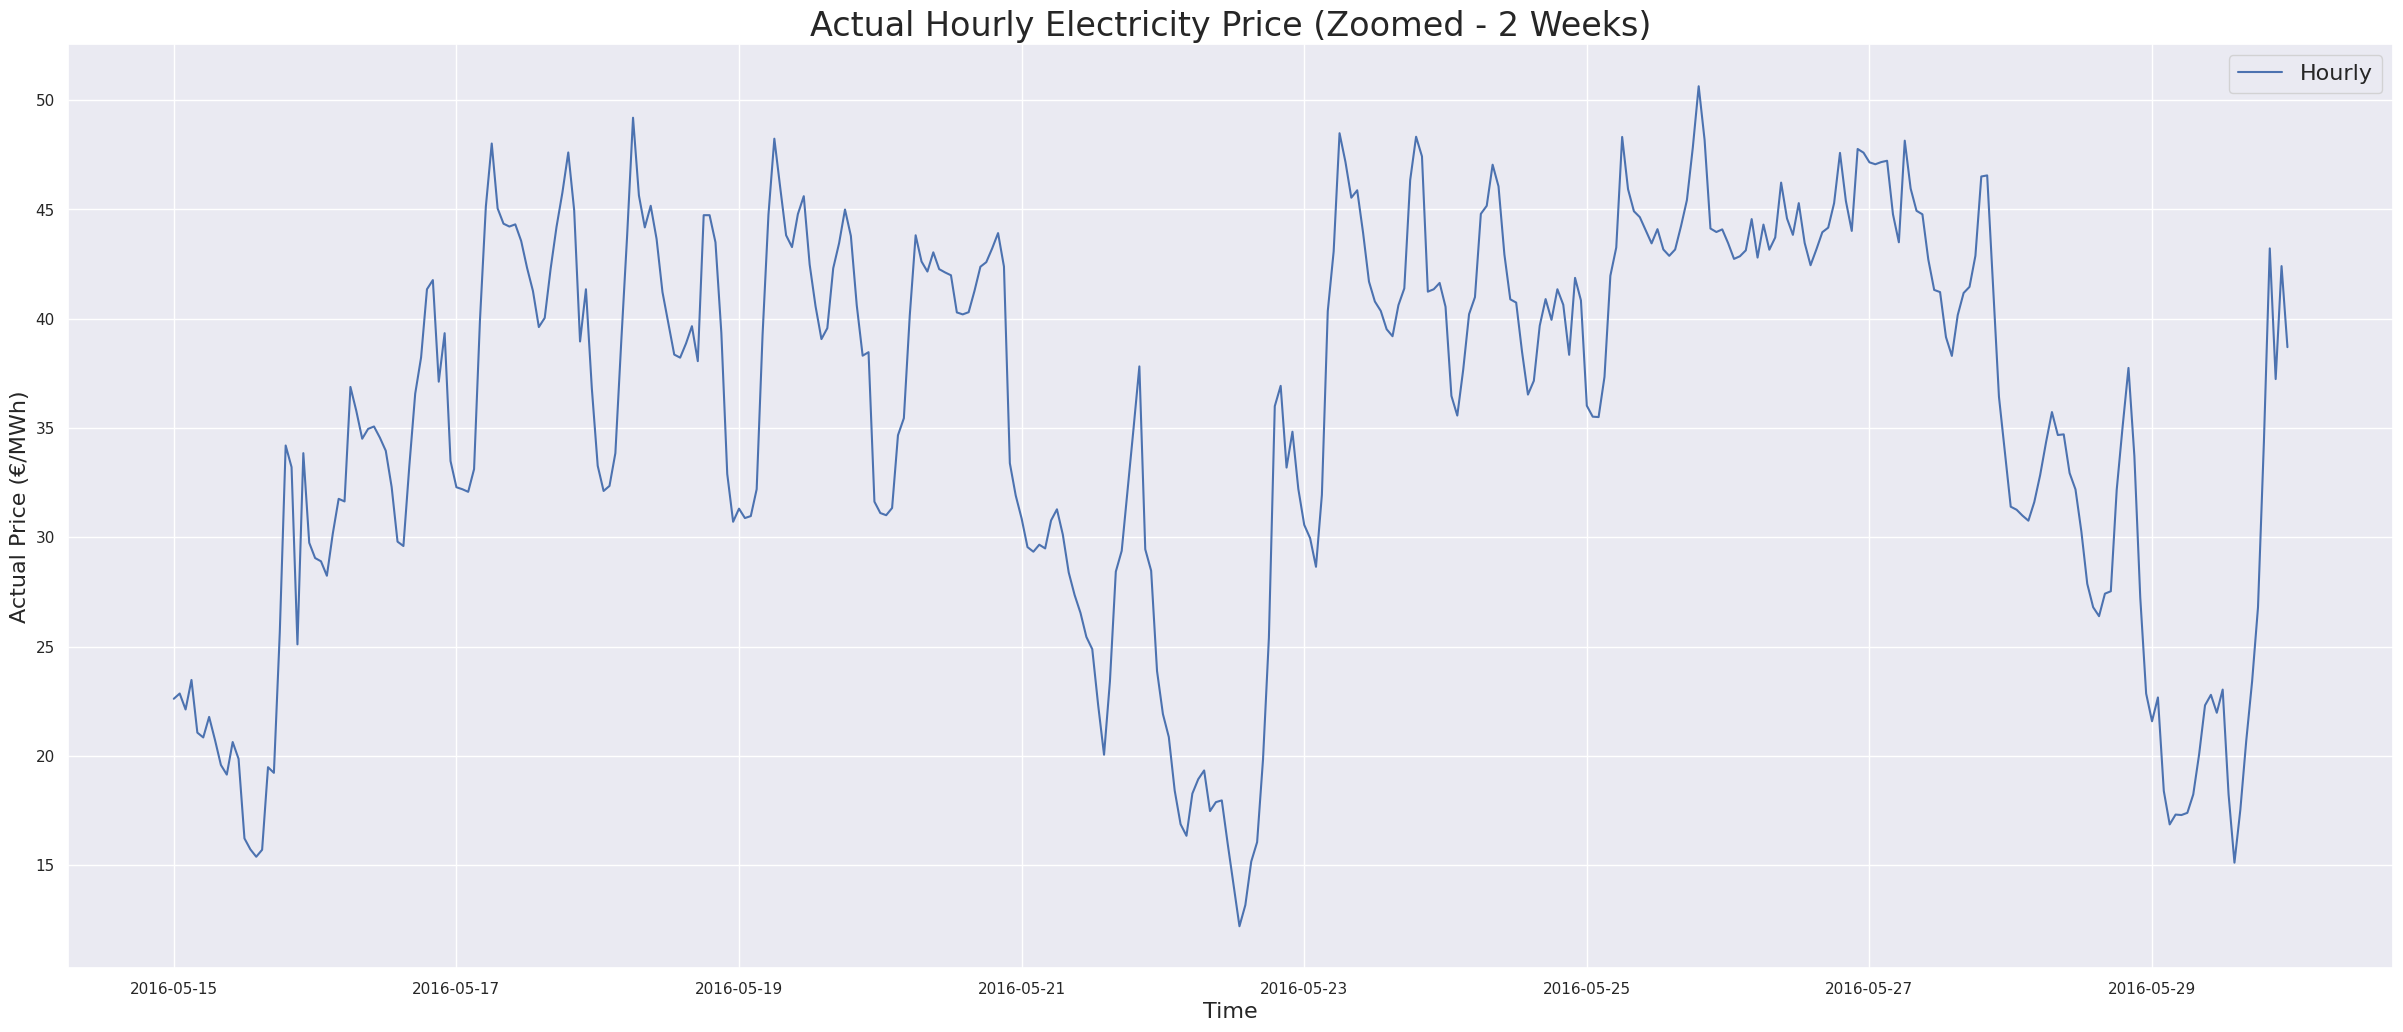

In [ ]:
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

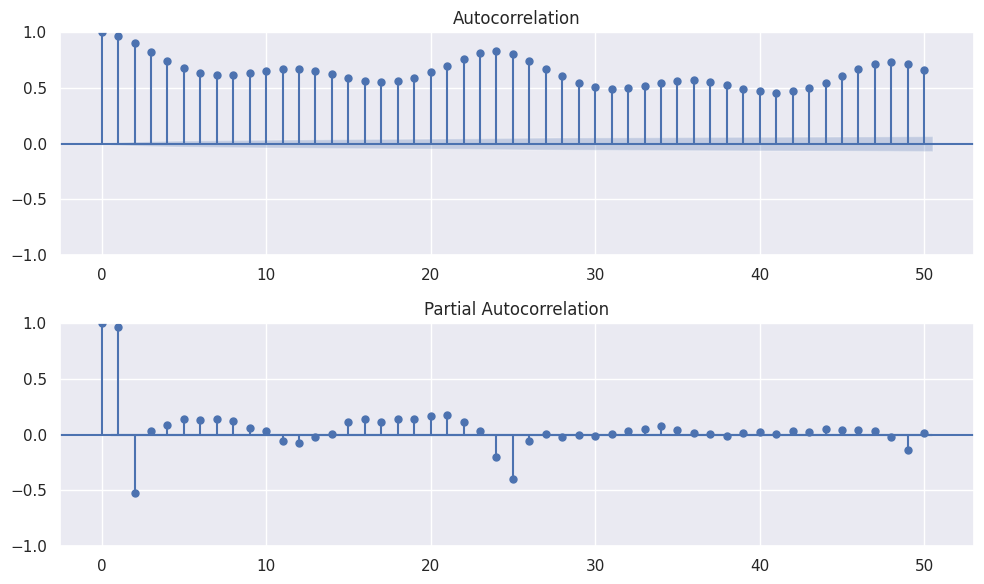

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

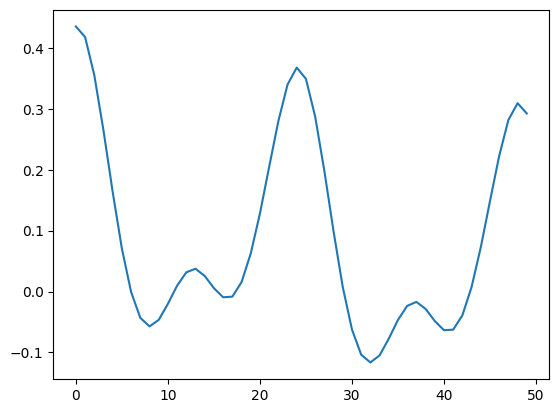

In [ ]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

In [ ]:
correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

In [24]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

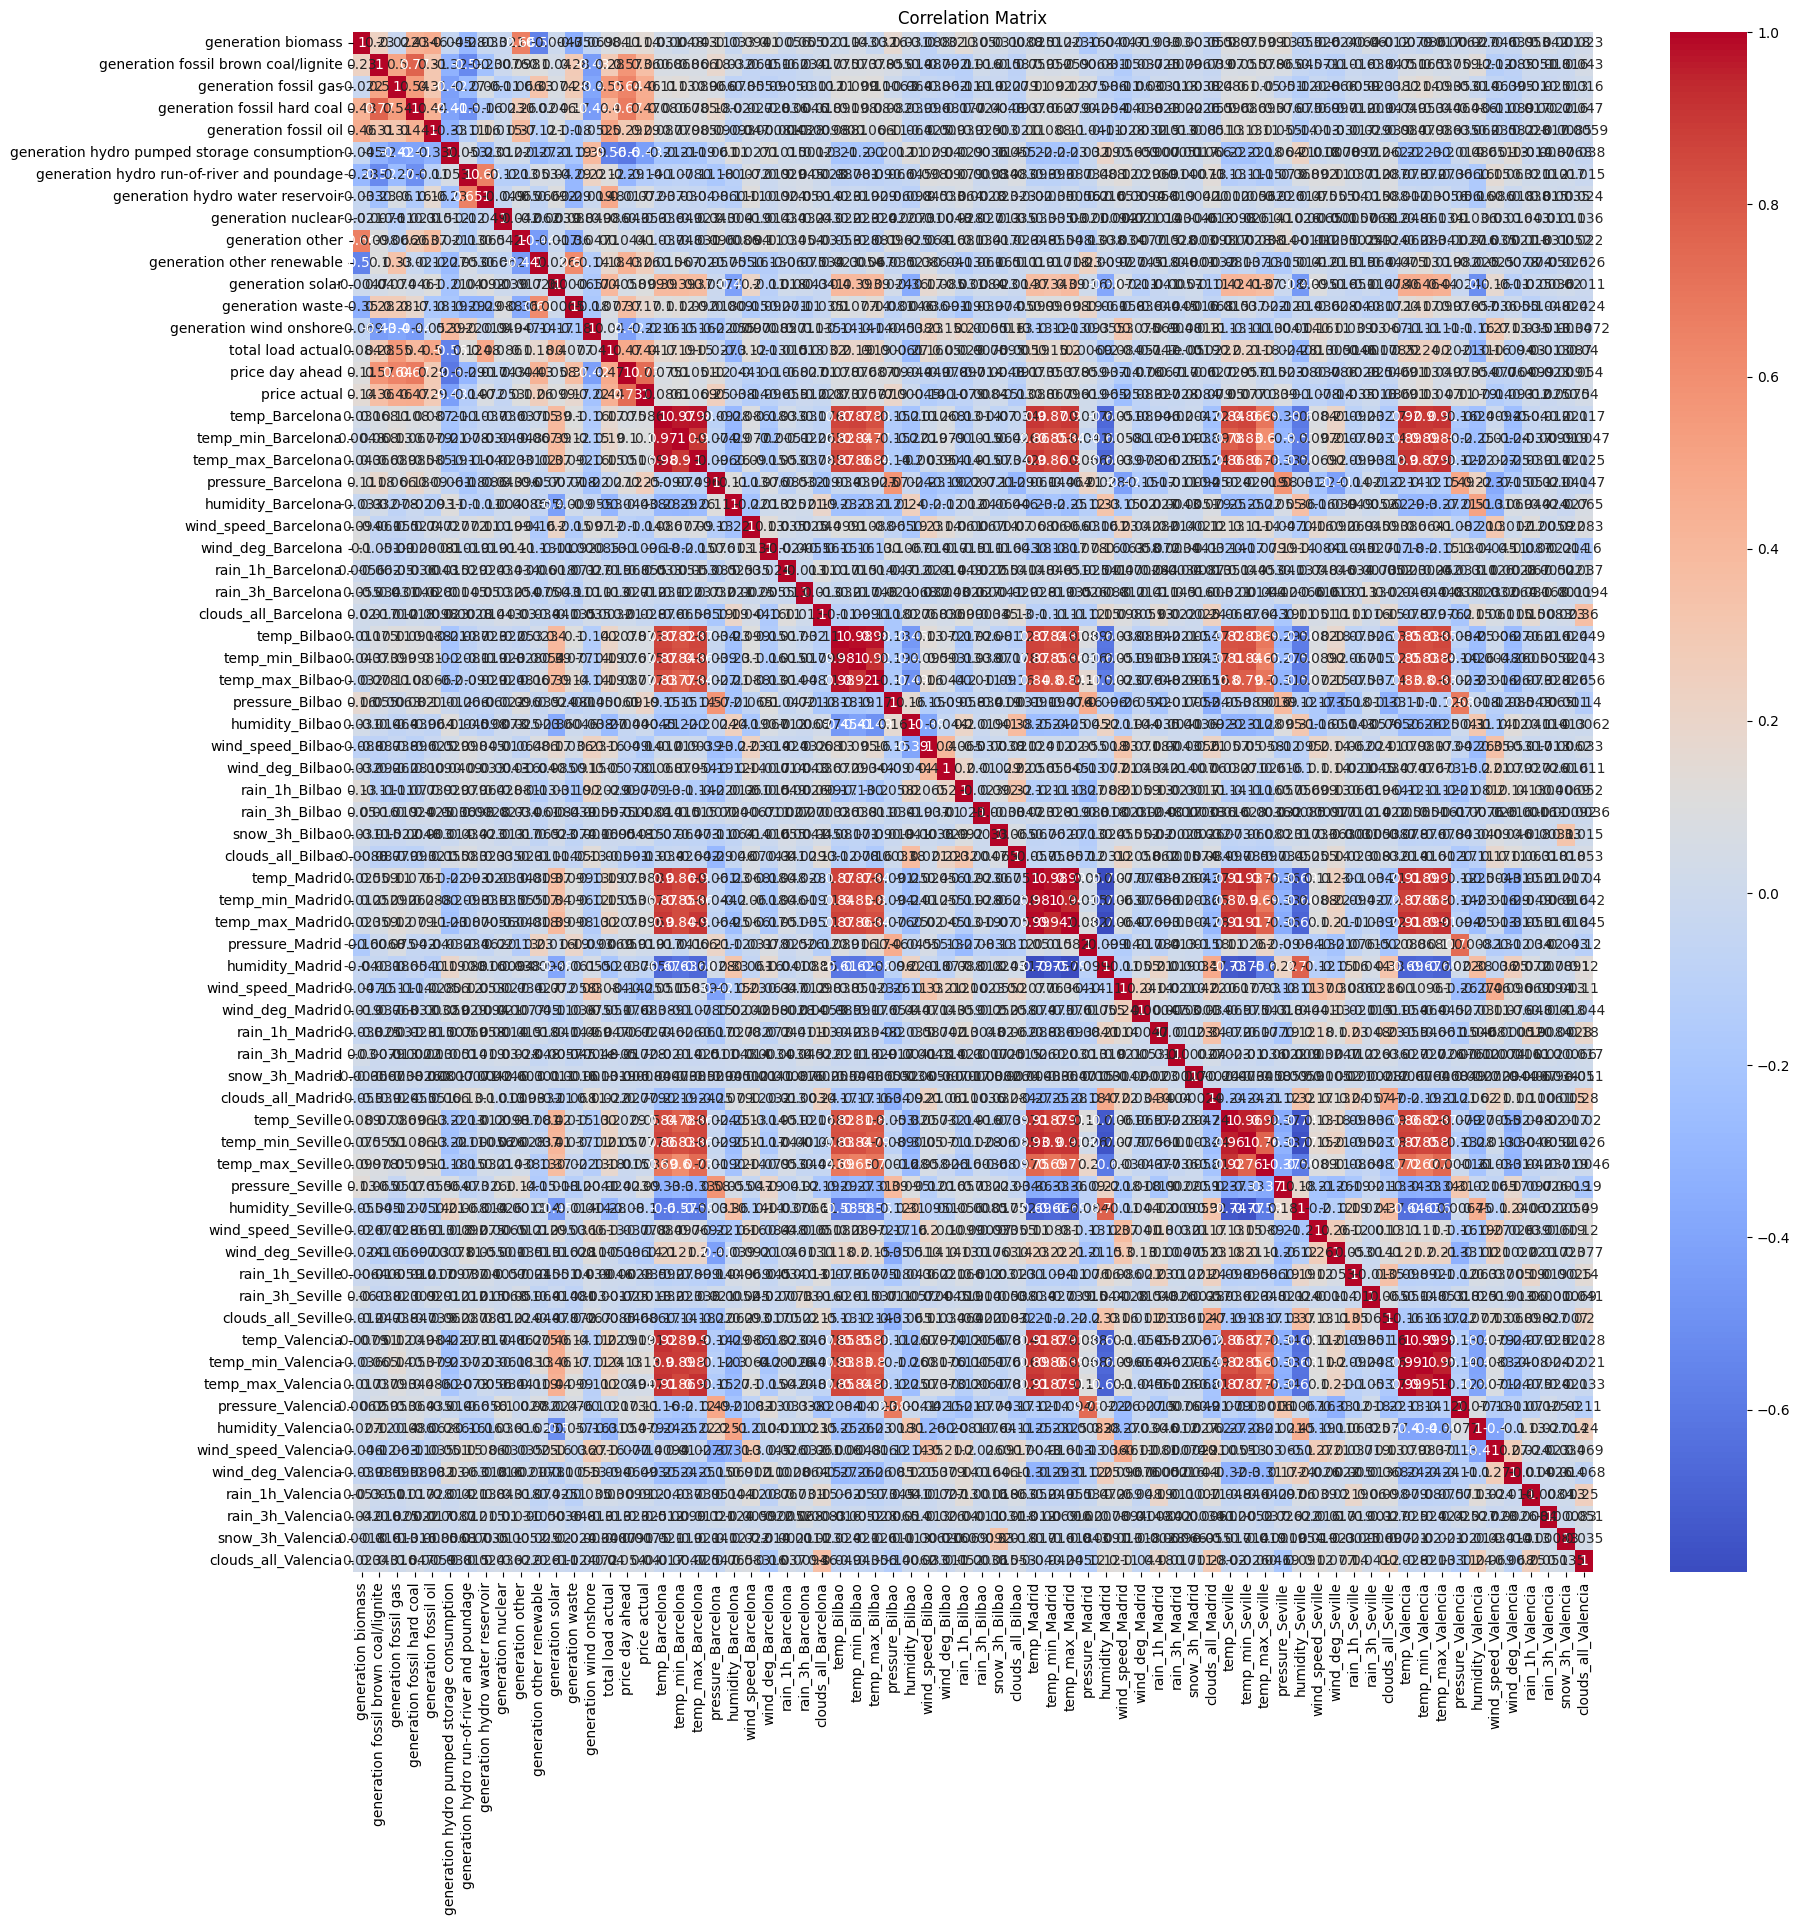

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
correlations = df_final.corr(method='pearson')


In [ ]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

In [25]:
df_final['hour'] = df_final.index.hour
df_final['weekday'] = df_final.index.weekday
df_final['month'] = df_final.index.month


In [26]:
hour = df_final.index.hour

conditions = [
    ((hour > 8) & (hour < 14)) | ((hour > 16) & (hour < 21)),
    (hour >= 14) & (hour <= 16)
]

choices = [2, 1]

df_final['business hour'] = np.select(conditions, choices, default=0)

In [27]:
hour = df_final.index.hour

conditions = [
    ((hour > 8) & (hour < 14)) | ((hour > 16) & (hour < 21)),
    (hour >= 14) & (hour <= 16)
]

choices = [2, 1]

df_final['business hour'] = np.select(conditions, choices, default=0)

In [28]:
weekday=df_final.index.weekday
conditions = [
    (weekday == 6),
    (weekday == 5)]
choices = [2, 1]
df_final['weekday'] = np.select(conditions, choices, default=0)


In [29]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final[f'temp_range_{city}'] = (df_final[f'temp_max_{city}'] - df_final[f'temp_min_{city}']).abs()


In [30]:
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [31]:
cities_weights = {'Madrid': weight_Madrid,
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [32]:
weighted_temps = [df_final[f'temp_{city}'] * weight for city, weight in cities_weights.items()]
df_final['temp_weighted'] = sum(weighted_temps)

In [33]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

In [34]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [35]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [36]:
scaler_X=MinMaxScaler(feature_range=(0,1))
scaler_y=MinMaxScaler(feature_range=(0,1))

In [37]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])


MinMaxScaler()

In [38]:
X_norm=scaler_X.transform(X)
y_norm=scaler_y.transform(y)

In [39]:
pca = PCA()
X_pca=pca.fit_transform(X_norm[:train_end_idx])

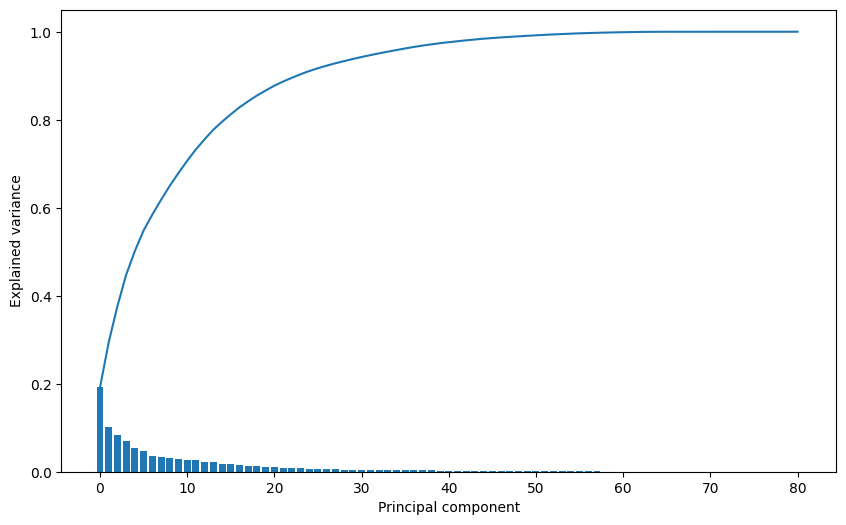

In [ ]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [40]:
pca = PCA(n_components=0.80)  #Here n_components=0.80 is the maximum threshold for varianc ethat we achive from our selected features
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [ ]:
X_pca.shape

(35064, 16)

In [41]:
dataset_norm=np.concatenate((X_pca,y_norm),axis=1)


In [42]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [43]:
past_history = 24
future_target = 0

In [44]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

In [45]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

In [46]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [47]:
batch_size = 32
buffer_size = 1000

In [48]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [54]:
input_shape = X_train.shape[-2:]
input_shape


(24, 17)

In [ ]:
input_shape = X_train.shape
input_shape

(27024, 24, 17)

In [50]:

loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [ ]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [56]:
def plot_model_rmse_and_loss(history):


    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']


    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

In [58]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [59]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8228 - root_mean_squared_error: 0.6988

845/845 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - loss: 0.8220 - root_mean_squared_error: 0.6984 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0061 - root_mean_squared_error: 0.0774

845/845 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.0061 - root_mean_squared_error: 0.0774 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 3/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0048 - root_mean_squared_error: 0.0685

845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.0048 - root_mean_squared_error: 0.0685 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 4/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0495
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0029 - root_mean_squared_error: 0.0533 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0518
Epoch 7/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0025 - root_mean_squared_error: 0.0492

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 0.0025 - root_mean_squared_error: 0.0492 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 8/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0024 - root_mean_squared_error: 0.0482 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0515
Epoch 9/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - loss: 0.0023 - root_mean_squared_error: 0.0474 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 10/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 11/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 12/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 13/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 14/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410

845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 15/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 16/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 17/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 18/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 19/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 20/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 21/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 22/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359

845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 23/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 24/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0381
Epoch 25/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 26/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 27/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 28/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 29/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 30/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 31/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 32/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 33/120
845/845 ━━━━━━━━━━━━━━━━━━━━

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 34/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316

845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 35/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 9.9936e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 36/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 9.7507e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 37/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 9.9847e-04 - root_mean_squared_error: 0.0314 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 38/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.5391e-04 - root_mean_squared_error: 0.0308

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 9.5351e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 39/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.2774e-04 - root_mean_squared_error: 0.0304

845/845 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 9.2756e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 40/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 9.4008e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 41/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 9.2726e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 42/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.9509e-04 - root_mean_squared_error: 0.0298

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 8.9475e-04 - root_mean_squared_error: 0.0298 - val_loss: 9.8687e-04 - val_root_mean_squared_error: 0.0314
Epoch 43/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 8.9176e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 44/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 8.7583e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 45/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.4734e-04 - root_mean_squared_error: 0.0290

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 8.4686e-04 - root_mean_squared_error: 0.0290 - val_loss: 9.4641e-04 - val_root_mean_squared_error: 0.0308
Epoch 46/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 8.5528e-04 - root_mean_squared_error: 0.0292 - val_loss: 9.8996e-04 - val_root_mean_squared_error: 0.0315
Epoch 47/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 8.3341e-04 - root_mean_squared_error: 0.0288 - val_loss: 9.5826e-04 - val_root_mean_squared_error: 0.0310
Epoch 48/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 8.3486e-04 - root_mean_squared_error: 0.0288 - val_loss: 9.7668e-04 - val_root_mean_squared_error: 0.0313
Epoch 49/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 8.4526e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 50/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 8.1419e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
E

845/845 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - loss: 7.8296e-04 - root_mean_squared_error: 0.0279 - val_loss: 9.1789e-04 - val_root_mean_squared_error: 0.0303
Epoch 55/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.8565e-04 - root_mean_squared_error: 0.0279

845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 7.8533e-04 - root_mean_squared_error: 0.0279 - val_loss: 8.5800e-04 - val_root_mean_squared_error: 0.0293
Epoch 56/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - loss: 7.8892e-04 - root_mean_squared_error: 0.0280 - val_loss: 8.9349e-04 - val_root_mean_squared_error: 0.0299
Epoch 57/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 7.6603e-04 - root_mean_squared_error: 0.0276 - val_loss: 9.3299e-04 - val_root_mean_squared_error: 0.0305
Epoch 58/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 7.4573e-04 - root_mean_squared_error: 0.0272 - val_loss: 9.1737e-04 - val_root_mean_squared_error: 0.0303
Epoch 59/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 7.6240e-04 - root_mean_squared_error: 0.0275 - val_loss: 9.1858e-04 - val_root_mean_squared_error: 0.0303
Epoch 60/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 7.6874e-04 - root_mean_squared_error: 0.0276 - val_loss: 9.7540e-04 - val_root_mean_squared_error: 

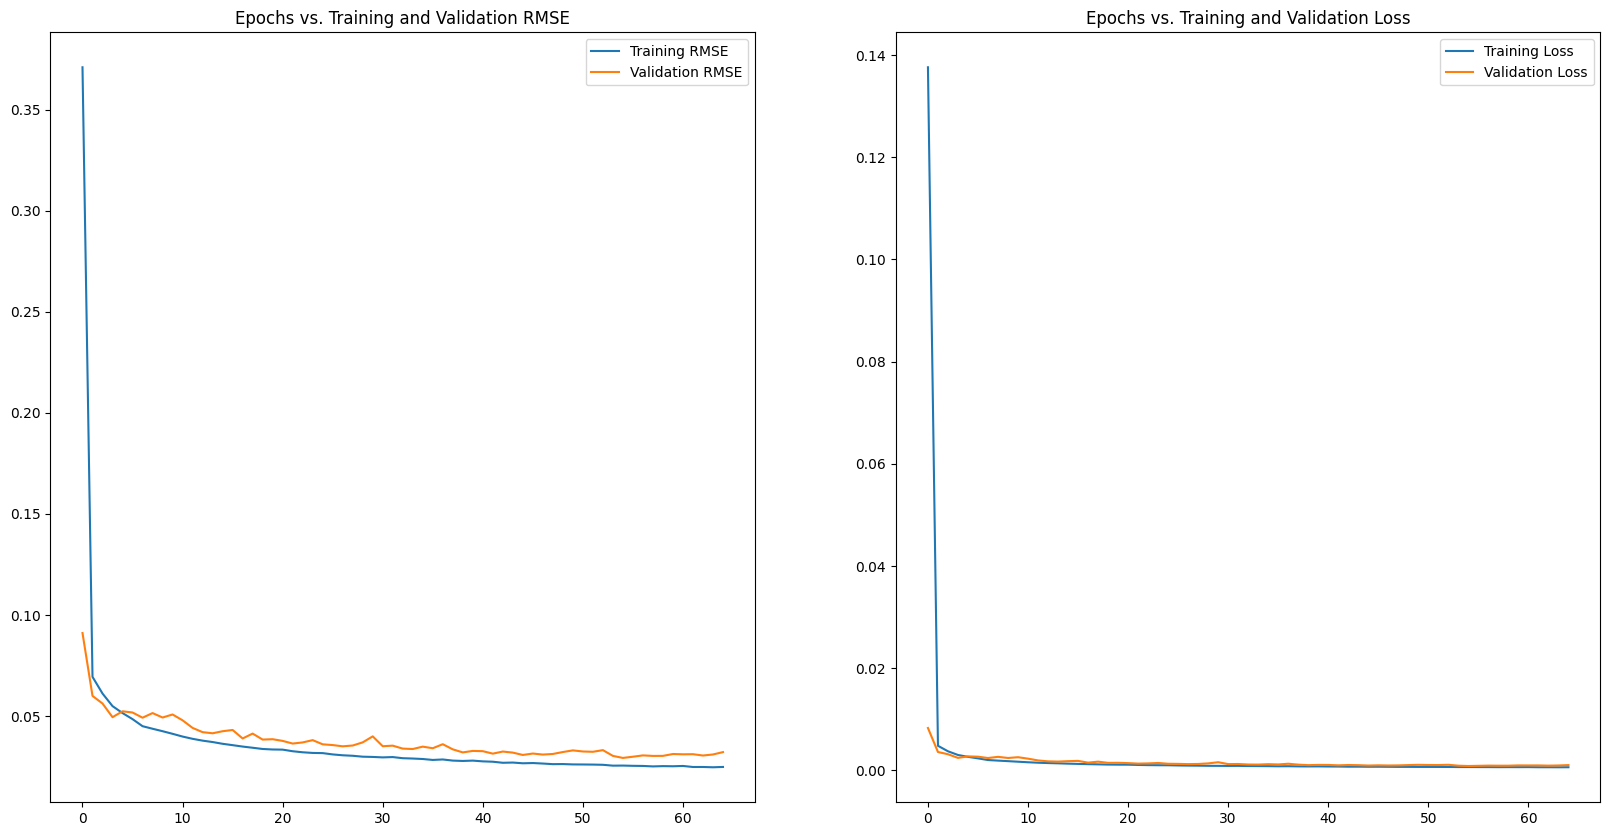

In [60]:
plot_model_rmse_and_loss(history)

In [62]:
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [63]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
RMSE of hour-ahead electricity price LSTM forecast: 2.368


In [ ]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))